# Replicating Propbulica's COMPAS Audit


## Why COMPAS?


Propublica started the COMPAS Debate with the article [Machine Bias](#References).  With their article, they also released details of their methodology and their [data and code](https://github.com/propublica/compas-analysis).  This presents a real data set that can be used for research on how data is used in a criminal justice setting without researchers having to perform their own requests for information, so it has been used and reused a lot of times.


Get started by configuring your notebook `%load code/config`

Then get the next instructions with: `mdshow('code/case.md')`

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import roc_curve
from utilities import *
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# %load code/data.md
## Propublica COMPAS Data

The dataset consists of COMPAS scores assigned to defendants over two years 2013-2014 in Broward County, Florida. These scores are determined by a proprietary algorithm designed to evaluate a persons recidivism risk - the likelihood that they will reoffend. Risk scoring algorithms are widely used by judges to inform their scentencing and bail decisions in the criminal justice system in the United States. The original ProPublica analysis identified a number of fairness concerns around the use of COMPAS scores, including that ''black defendants were nearly twice as likely to be misclassified as higher risk compared to their white counterparts.'' Please see the full article for further details.

Load the data and begin EDA with `%load code/data`


Then get the next instructions with `mdshow('code/clean.md')`

In [15]:
# %load code/data
df = pd.read_csv("https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years.csv",
                 header=0).set_index('id')

print(list(df))
print(df.head())

['name', 'first', 'last', 'compas_screening_date', 'sex', 'dob', 'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number', 'c_offense_date', 'c_arrest_date', 'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number', 'r_charge_degree', 'r_days_from_arrest', 'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid', 'is_violent_recid', 'vr_case_number', 'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc', 'type_of_assessment', 'decile_score.1', 'score_text', 'screening_date', 'v_type_of_assessment', 'v_decile_score', 'v_score_text', 'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1', 'start', 'end', 'event', 'two_year_recid']
                  name   first         last compas_screening_date   sex  \
id                                                                        
1     miguel hernandez  m

In [16]:
df.to_csv('data/compas.csv')

# %load code/clean.md
### Data Cleaning

For this analysis, we will restrict ourselves to only a few features, and clean the dataset according to the methods using in the original ProPublica analysis.

Details of the cleaning method can be found in the utilities file.

use `%load code/clean` to clean the data.

Discuss the changes:
- how much data was removed?
- note which columns were retained

Continue your eda with `mdshow('code/explore.md')`

In [3]:
# %load code/clean
# Select features that will be analyzed
features_to_keep = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
                    'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in',
                    'c_jail_out']
df = df[features_to_keep]
df = clean_compas(df)
df.head()
print("\ndataset shape (rows, columns)", df.shape)

Number of rows removed: 1042
Features: ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out', 'length_of_stay']

dataset shape (rows, columns) (6172, 14)


In [14]:
df.to_csv('data/compas_c.csv')

# %load code/explore.md
## Data Exploration

Next we provide a few ways to look at the relationships between the attributes in the dataset. Here is an explanation of these values:

* `age`: defendant's age
* `c_charge_degree`: degree charged (Misdemeanor of Felony)
* `race`: defendant's race
* `age_cat`: defendant's age quantized in "less than 25", "25-45", or "over 45"
* `score_text`: COMPAS score: 'low'(1 to 5), 'medium' (5 to 7), and 'high' (8 to 10).
* `sex`: defendant's gender
* `priors_count`: number of prior charges
* `days_b_screening_arrest`: number of days between charge date and arrest where defendant was screened for compas score
* `decile_score`: COMPAS score from 1 to 10 (low risk to high risk)
* `is_recid`: if the defendant recidivized
* `two_year_recid`: if the defendant within two years
* `c_jail_in`: date defendant was imprisoned
* `c_jail_out`: date defendant was released from jail
* `length_of_stay`: length of jail stay

In particular, as in the ProPublica analysis, we are interested in the implications for the treatment of different groups as defined by some **protected attribute**. In particular we will consider race as the protected attribute in our analysis. Next we look at the number of entries for each race.


1. Use `value_counts` to look at how much data is available for each race
2. filter to keep data from the two larges groups (help via `%load filter`)

Next step: `mdshow(code/dist.md)`

In [4]:
df['race'].value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64

In [5]:
# %load code/filter
df = df.loc[df['race'].isin(['African-American','Caucasian'])]

### COMPAS score distribution

Let's look at the COMPAS score distribution between African-Americans and Caucasians (matches the one in the ProPublica article).

hint: (use shift + tab for help in any function)
```
race_score_table = df.groupby([]).size().reset_index().pivot(index='',columns='',values=0)

# print percentage of defendants in each score category
(100*/.sum()).transpose()
```

_or get more help with `%load code/racetable`_

then make a bar plot (quickest way is to use pandas plot with `figsize=[12,7]` to make it bigger, plot type is indicated by the `kind` parameter)

Next steps at `mdshow('code/gapexplore')`

In [6]:
# %load code/racetable
race_score_table = df.groupby(['race','decile_score']).size().reset_index().pivot(
                                index='decile_score',columns='race',values=0)

# percentage of defendants in each score category
(100*race_score_table/race_score_table.sum()).transpose()

decile_score,1,2,3,4,5,6,7,8,9,10
race,,,,,,,,,,
African-American,11.496063,10.897638,9.385827,10.614173,10.173228,10.015748,10.803150,9.480315,9.984252,7.149606
Caucasian,28.768426,15.263909,11.317166,11.554922,9.510223,7.608179,5.373276,4.564907,3.661436,2.377556


<AxesSubplot:xlabel='decile_score'>

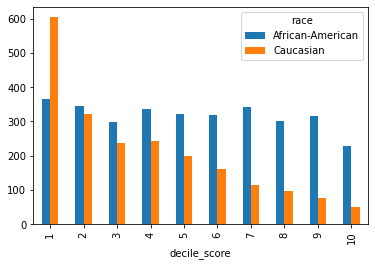

In [7]:
race_score_table.plot(kind='bar')

<!-- # %load code/gapexplore.md -->
As you can observe, there is a large discrepancy. Does this change when we condition on other variables?

1. Look at how priors are distributed. Follow what you did above for score by race or use `%load code/priors` for help
1. Look at how scores are distributed for those with more than two priors (`%load code/2priorscores`)
1. What about with less than two priors ?(you can copy or import again the above and modify it)
1. Look at first time (use `priors_count`) felons (`c_charge_degree` of `F`) under 25. How is this different?


Then `mdshow('code/actual.md')`

<AxesSubplot:xlabel='priors_count'>

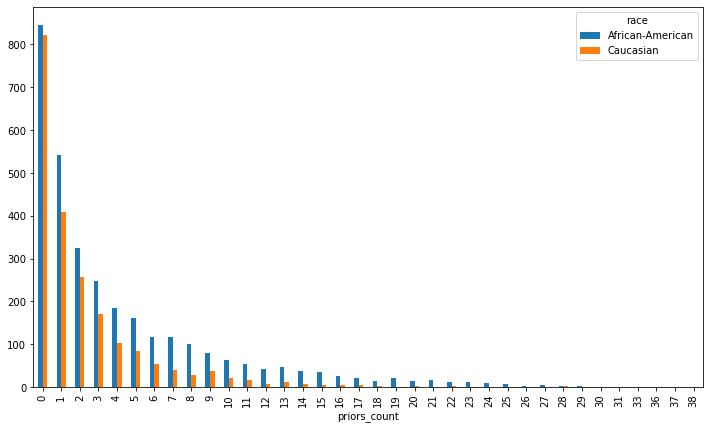

In [8]:
# %load code/priors
priors = df.groupby(['race','priors_count']).size().reset_index().pivot(index='priors_count',columns='race',values=0)
priors.plot(kind='bar',figsize=[12,7])

<AxesSubplot:xlabel='decile_score'>

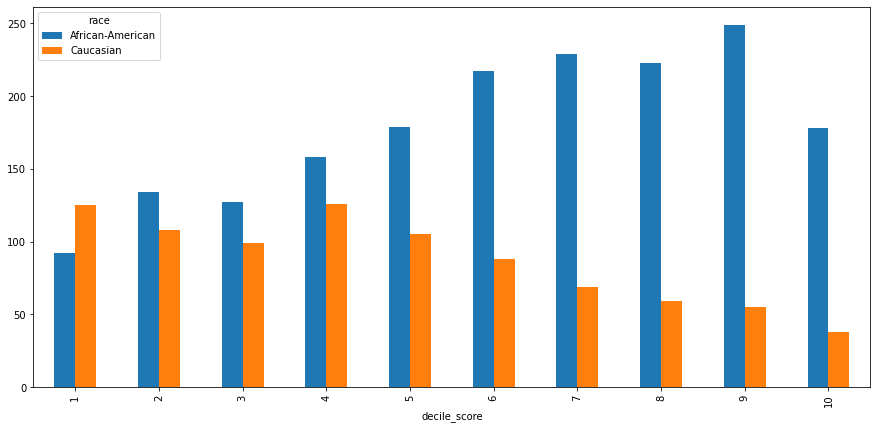

In [9]:
# %load code/2priorscores
df_2priors = df.loc[df['priors_count']>=2]
score_2priors = df_2priors.groupby(['race','decile_score']).size().reset_index().pivot(
    index='decile_score',columns='race',values=0)
score_2priors.plot(kind='bar',figsize=[15,7])

<!-- # %load code/actual.md -->
## What happens when we take actual 2-year recidivism values into account? Are the predictions fair?

First quantize the data
`%load code/quantize`

First, let's look at the correlation between the quantized score, the decile score and the actual recidivism.

```
# measure with high-low score
print(dfQ[['two_year_recid','score_text']].corr())

# measure with decile_score
print(dfQ[['two_year_recid','decile_score']].corr())
```

The correlation is not that high. How can we evaluate whether the predictions made by the COMPAS scores are fair, especially considering that they do not predict recidivism rates well? `mdshow('code/fair.md')`

In [10]:
# %load code/quantize
dfQ = df.copy()

# Quantize priors count between 0, 1-3, and >3
def quantizePrior(x):
    if x <=0:
        return '0'
    elif 1<=x<=3:
        return '1 to 3'
    else:
        return 'More than 3'


# Quantize length of stay
def quantizeLOS(x):
    if x<= 7:
        return '<week'
    if 8<x<=93:
        return '<3months'
    else:
        return '>3 months'

# Quantize length of stay
def adjustAge(x):
    if x == '25 - 45':
        return '25 to 45'
    else:
        return x

# Quantize score_text to MediumHigh
def quantizeScore(x):
    if (x == 'High')| (x == 'Medium'):
        return 1
    else:
        return 0


dfQ['priors_count'] = dfQ['priors_count'].apply(quantizePrior)
dfQ['length_of_stay'] = dfQ['length_of_stay'].apply(quantizeLOS)
dfQ['score_text'] = dfQ['score_text'].apply(quantizeScore)
dfQ['age_cat'] = dfQ['age_cat'].apply(adjustAge)

In [13]:
dfQ.to_csv('data/compas_cq.csv')

In [11]:
# measure with high-low score
dfQ[['two_year_recid','score_text']].corr()

,two_year_recid,score_text
two_year_recid,1.000000,0.314698
score_text,0.314698,1.000000


In [12]:
# measure with decile_score
dfQ[['two_year_recid','decile_score']].corr()

,two_year_recid,decile_score
two_year_recid,1.000000,0.368193
decile_score,0.368193,1.000000


<!-- # %load code/fair.md -->


##  Fairness Metrics

The question of how to determine if an algorithm is *fair* has seen much debate recently (see this tutorial from the Conference on Fairness, Acountability, and Transparency titled [21 Fairness Definitions and Their Politics](https://fatconference.org/2018/livestream_vh220.html).

And in fact some of the definitions are contradictory, and have been shown to be mutually exclusive [2,3] https://www.propublica.org/article/bias-in-criminal-risk-scores-is-mathematically-inevitable-researchers-say

Here we will cover 3 notions of fairness and present ways to measure them:

1. **Disparate Impact** [4](#References)
[The 80% rule](https://en.wikipedia.org/wiki/Disparate_impact#The_80.25_rule)

2. **Calibration** [6](#References)

4. **Equalized Odds** [5](#References)

For the rest of our analysis we will use a binary outcome - COMPAS score <= 4 is LOW RISK, >4 is HIGH RISK.

### Disparate Impact

Disparate impact is a legal concept used to describe situations when an entity such as an employer *inadvertently* discriminates gainst a certain protected group. This is distinct from *disparate treatment* where discrimination is intentional.

To demonstrate cases of disparate impact, the Equal Opportunity Commission (EEOC) proposed "rule of thumb" is known as the [The 80% rule](https://en.wikipedia.org/wiki/Disparate_impact#The_80.25_rule).

Feldman et al. [4](#References) adapted a fairness metric from this  principle. For our application, it states that the percent of defendants predicted to be high risk in each protected group (in this case whites and african-americans) should be within 80% of each other.

Let's evaluate this standard for the COMPAS data.

`%load code/di` then `mdshow('code/evaldi.md')`

In [17]:
# %load code/di
#  Let's measure the disparate impact according to the EEOC rule
means_score = dfQ.groupby(['score_text','race']).size().unstack().reset_index()
means_score = means_score/means_score.sum()
means_score
# split this cell for the above to print
# compute disparate impact
AA_with_high_score = means_score.loc[1,'African-American']
C_with_high_score = means_score.loc[1,'Caucasian']

C_with_high_score/AA_with_high_score

0.5745131730114521

# %load code/evaldi.md
This ratio is below .8, so there is disparate impact by this rule.  (Taking the priveleged group and the undesirable outcome instead of the disadvantaged group and the favorable outcome).

What if we apply the same rule to the **true** two year rearrest instead of the quantized COMPAS score?

`%load code/rearrestdi`

then `mdshow('code/calibration.md')`

In [18]:
# %load code/rearrestdi
means_2yr = dfQ.groupby(['two_year_recid','race']).size().unstack()
means_2yr = means_2yr/means_2yr.sum()
means_2yr

# compute disparte impact
AA_with_high_score = means_2yr.loc[1,'African-American']
C_with_high_score = means_2yr.loc[1,'Caucasian']
C_with_high_score/AA_with_high_score

0.7471480065031378

# %load code/calibration.md
There is a difference in re-arrest, but not as high as assigned by the COMPAS scores. This is still a disparate impact of the actual arrests (since this not necesarrily accurate as a recidivism rate, but it is true rearrest).

Now let's measure the difference in scores when we consider both the COMPAS output and true recidivism.

### Calibration

A discussion of using calibration to verify the fairness of a model can be found in Northpoint's (now: Equivant) response to the ProPublica article [6](#References).

The basic idea behind calibrating a classifier is that you want the confidence of the predictor to reflect the true outcomes. So, in a well-calibrated classifier, if 100 people are assigned 90% confidence of being in the positive class, then in reality, 90 of them should actually have had a positive label.

To use calibration as a fairness metric we compare the calibration of the classifier for each group.  The smaller the difference, the more fair the calssifier.

In our problem this can be expressed as given $Y$ indicating two year recidivism, $S_Q$ indicating score (0=low, 1=high medium), and $R$ indicating race, we measure

$$\mathsf{cal} \triangleq \frac{\mathbb{P}\left(Y=1\mid S_Q=s,R=\mbox{African-American} \right)}{\mathbb{P}\left(Y=1 \mid S_Q=s,R=\mbox{Caucasian} \right)},$$ for different scores $s$. Considering our quantized scores, we look at the calibration for $s=1$.

compute this with `%load calibration`

#### Discuss
1. Do you think this is close enough?
1. Which metric do you think is better so far?

Next: `mdshow('code/pp.md')`

In [19]:
# %load code/calibration
# compute averages
dfAverage = dfQ.groupby(['race','score_text'])['two_year_recid'].mean().unstack()

num = dfAverage.loc['African-American',1]
denom = dfAverage.loc['Caucasian',1]
cal = num/denom
calpercent = 100*(cal-1)
print('Calibration: %f' % cal)
print('Calibration in percentage: %f%%' % calpercent)

Calibration: 1.091972
Calibration in percentage: 9.197233%


# %load code/pp.md
The difference looks much smaller than before. The problem of the above calibration measure is that it depends on the threshold on which we quantized the scores $S_Q$.

In order to mitigate this, ine might use a variation of this measure called *predictive parity.* In this example, we define predictive parity as

$$\mathsf{PP}(s) \triangleq \frac{\mathbb{P}\left(Y=1\mid S\geq s,R=\mbox{African-American} \right)}{\mathbb{P}\left(Y=1 \mid S\geq s,R=\mbox{Caucasian} \right)},$$
where $S$ is the original score.

We plot $\mathsf{PP}(s) $ for $s$ from 1 to 10. Note how predictive parity depends significantly on the threshold.

Try this out with `%load code/pp`

Then try the next metric with `mdshow('code/eq.md')`

Text(0.5, 1.0, 'Predictive parity for different thresholds\n(warning: no error bars)')

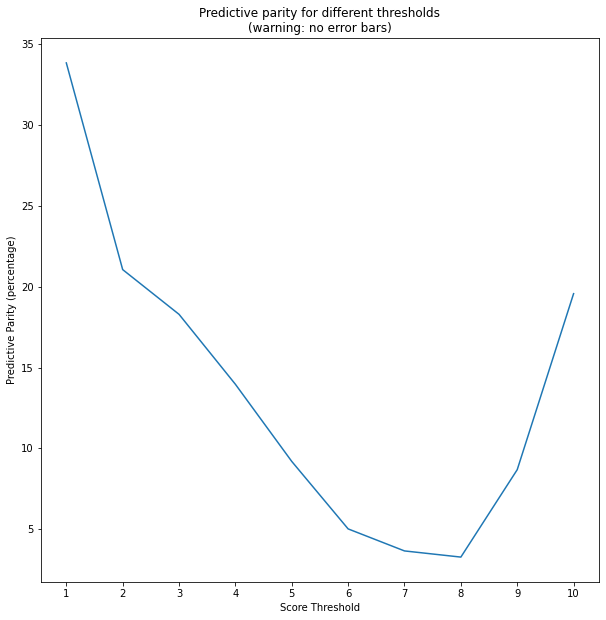

In [20]:
# %load code/pp
# aux function for thresh score
def threshScore(x,s):
    if x>=s:
        return 1
    else:
        return 0

ppv_values = []
dfP = dfQ[['race','two_year_recid']].copy()
for s in range(1,11):
    dfP['threshScore'] = dfQ['decile_score'].apply(lambda x: threshScore(x,s))
    dfAverage = dfP.groupby(['race','threshScore'])['two_year_recid'].mean().unstack()
    num = dfAverage.loc['African-American',1]
    denom = dfAverage.loc['Caucasian',1]
    ppv_values.append(100*(num/denom-1))


plt.figure(figsize=[10,10])
plt.plot(range(1,11),ppv_values)
plt.xticks(range(1,11))
plt.xlabel('Score Threshold')
plt.ylabel('Predictive Parity (percentage)')
plt.title('Predictive parity for different thresholds\n(warning: no error bars)')

# %load code/eq.md
### Equalized Odds

The last fairness metric we consider is based on the difference in *error rates* between groups. Hardt et al. [5](#References) propose to look at the difference in the true positive and false positive rates for each group. This aligns with the analysis performed by Propublica. We can examine these values looking at is the ROC for each group. We normalize the score between 0 and 1. The ROC thresholds produced by `scikitlearn` are the same.

`%load code/eq`

Discuss these results and copmare how these metrics show that there is (or is not) a disparity.  


For an extra activity if you finish early, consider CORELS with `mdshow('code/corels.md')`

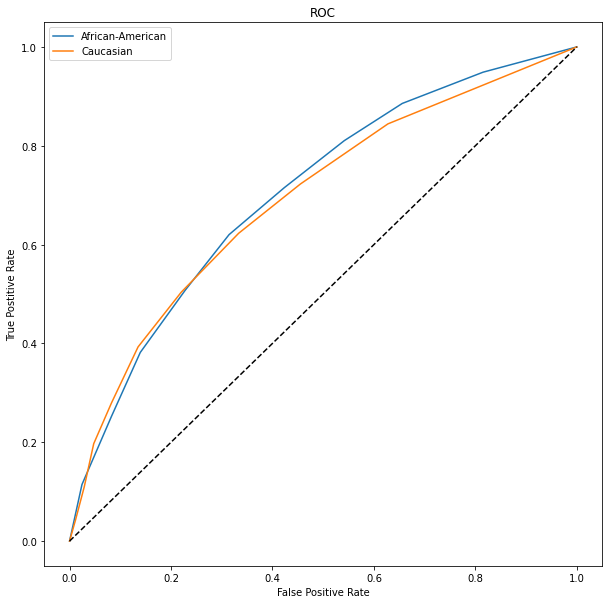

In [21]:
# %load code/eq
# normalize decile score
max_score = dfQ['decile_score'].max()
min_score = dfQ['decile_score'].min()
dfQ['norm_score'] = (dfQ['decile_score']-min_score)/(max_score-min_score)


plt.figure(figsize=[10,10])
#plot ROC curve for African-Americans
y = dfQ.loc[dfQ['race']=='African-American',['two_year_recid','norm_score']].values
fpr1,tpr1,thresh1 = roc_curve(y_true = y[:,0],y_score=y[:,1])
plt.plot(fpr1,tpr1)

#plot ROC curve for Caucasian
y = dfQ.loc[dfQ['race']=='Caucasian',['two_year_recid','norm_score']].values
fpr2,tpr2,thresh2 = roc_curve(y_true = y[:,0],y_score=y[:,1])
plt.plot(fpr2,tpr2)
l = np.linspace(0,1,10)
plt.plot(l,l,'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Postitive Rate')
plt.title('ROC')
plt.legend(['African-American','Caucasian'])

# %load code/corels.md
# Corels

COPMAS has also been critcized for being a generally opaque system.

We saw during the interpretability class, the [CORELS system](https://corels.eecs.harvard.edu/corels/run.html). It learns a rule list from the Propulica data and reports similar accuracy.

```
if ({Prior-Crimes>3}) then ({label=1})
else if ({Age=18-22}) then ({label=1})
else ({label=0})
```

Let's investigate how that score compares.
1. Write a function that takes one row of the data frame and computes the corels function
1. Use `df.apply` to apply your function and add a column to the data frame with the corels score
1. Evaluate the CORELS prediction with respect to accuracy, and fairnss follwing the above

Starter code is in `%load code/corels`

In [22]:
df['age_cat'].value_counts()

25 - 45            4109
Greater than 45    1576
Less than 25       1529
Name: age_cat, dtype: int64

In [23]:
# %load code/corels

def corels_rule(row):
    if row['priors_count'] > 3:
        return True
    elif row['age'] == 'Less than 25':
        return True
    else:
        return False

df['corels'] = df.apply(corels_rule,axis=1)

#  Let's measure the disparate impact according to the EEOC rule
means_corel = df.groupby(['corels','race']).size().unstack().reset_index()
means_corel = means_corel/means_corel.sum()
means_corel

race,corels,African-American,Asian,Caucasian,Hispanic,Native American,Other
0,0.0,0.602273,0.84375,0.760391,0.814757,0.555556,0.814324
1,1.0,0.397727,0.15625,0.239609,0.185243,0.444444,0.185676
